# ENN583 Week 9 - Deep Learning for Image Retrieval

This week's practical will explore 2 different approaches to place recognition that use deep learning:
* AlexNet - a global descriptor from AlexNet when pre-trained on ImageNet
* HDC-DELF - local descriptors extracted from a DELF network and combined with hyperdimensional computing to create a global descriptor. The DELF network is built off a ResNet50 backbone.

To do these experiments, we will use the [VPR tutorial github](https://github.com/stschubert/VPR_Tutorial/tree/main) and adapt their demo script.

## Step 1: Clone the Visual Place Recognition Tutorial Github
Clone the [VPR tutorial github](https://github.com/stschubert/VPR_Tutorial/tree/main).

In [1]:
!git clone https://github.com/stschubert/VPR_Tutorial.git

fatal: destination path 'VPR_Tutorial' already exists and is not an empty directory.


## Step 2: Install and import necessary libraries

In [34]:
!pip install tensorflow
!pip install tensorflow_hub

import argparse
import configparser
import os
import sys

from VPR_Tutorial.evaluation.metrics import createPR, recallAt100precision, recallAtK
from VPR_Tutorial.evaluation import show_correct_and_wrong_matches
from VPR_Tutorial.matching import matching
from VPR_Tutorial.datasets.load_dataset import GardensPointDataset, StLuciaDataset, SFUDataset
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from IPython.display import display

from matplotlib import pyplot as plt

from glob import glob
from PIL import Image

## Step 3: Load and visualise the datasets


In [3]:
dataset = GardensPointDataset('VPR_Tutorial/images/GardensPoint/')
imgs_db, imgs_q, GThard, GTsoft = dataset.load()

===== Load dataset GardensPoint day_right--night_right


The gardens point dataset has 200 images in both the database and query set. There is a 1-to-1 correspondence between the database and query set --  images with the same ID were recorded at same places, i.e., the i-th database image matches the i-th query image. You can see this below, in the ground-truth assignment matrix, where there is a ground-truth match between the database and query set along the diagonal.


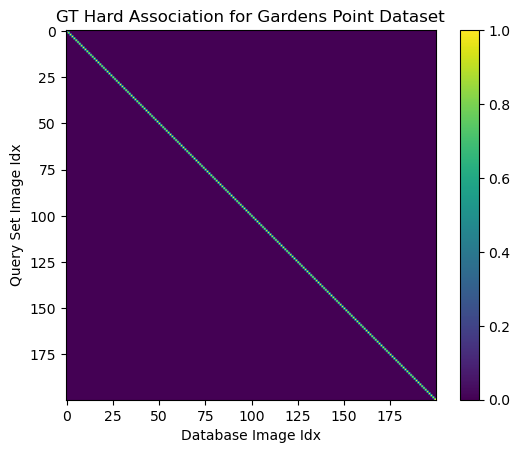

In [4]:
plt.imshow(GThard)
plt.colorbar()
plt.xlabel('Database Image Idx')
plt.ylabel('Query Set Image Idx')
plt.title('GT Hard Association for Gardens Point Dataset')
plt.show()

Let's view some of the images in the database and query set to get a sense of the data, as well as the main challenge of this dataset!

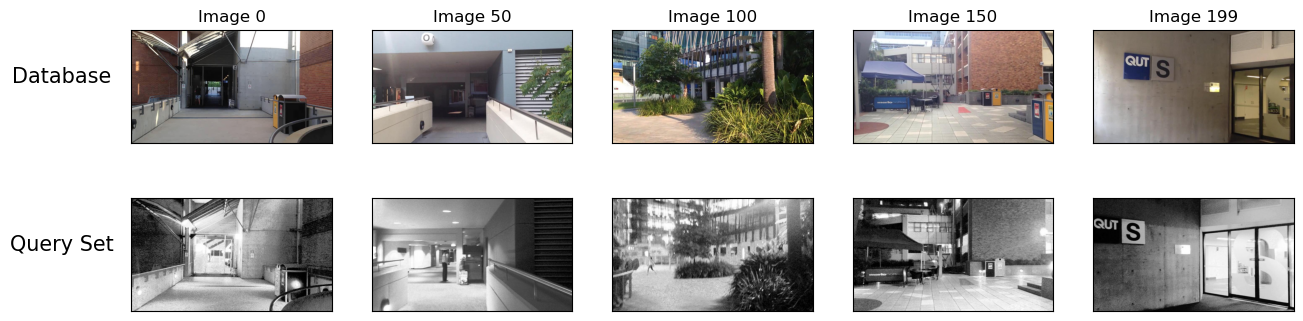

In [5]:
im_idxs = [0, 50, 100, 150, 199]

fig, ax = plt.subplots(2, 5, figsize = (15, 4))
for i, idx in enumerate(im_idxs):

    ax[0, i].imshow(imgs_db[idx])
    ax[1, i].imshow(imgs_q[idx])
    
    ax[0, i].set_xticks([]) #turns off axis ticks, which can be nicer for images
    ax[1, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].set_yticks([])
    
    ax[0, i].set_title(f'Image {idx}')

ax[0, 0].set_ylabel('Database', rotation = 0, labelpad = 50, fontsize = 15)
ax[1, 0].set_ylabel('Query Set', rotation = 0, labelpad = 50, fontsize = 15)

plt.show()

Can you see what the change to visual conditions is that would make this place recognition task challenging?

## Step 4: Load a feature extractor and compute feature descriptors

The main source of information about image correspondences are image feature descriptors. Local descriptors like DELF provide information for multiple regions of interest but are computationally expensive to compare. Holistic image descriptors like AlexNet reduce the computational complexity, but often have slightly lower performance. Feature aggregation methods such as Bag of Words, VLAD, or HDC can be used to combine the local descriptors of an image in a single holistic descriptor vector.

In the following, you can select either a holistic (AlexNet) or local image descriptor (HDC-DELF). Try AlexNet first, then come back and compare performance to HDC-DELF.


In [6]:
# Widget for selecting a descriptor
def select_descriptor(Descriptor=['AlexNet','HDC-DELF']):
    return Descriptor
w = interactive(select_descriptor)
display(w)

interactive(children=(Dropdown(description='Descriptor', options=('AlexNet', 'HDC-DELF'), value='AlexNet'), Ou…

In [51]:
# select descriptor
descriptor = w.result

print(f'===== Compute {descriptor} descriptors')
feature_extractor = None
if descriptor == 'HDC-DELF':
    from VPR_Tutorial.feature_extraction.feature_extractor_holistic import HDCDELF
    sys.path.append(os.path.join(os.getcwd(), "VPR_Tutorial"))
    feature_extractor = HDCDELF()
elif descriptor == 'AlexNet':
    from VPR_Tutorial.feature_extraction.feature_extractor_holistic import AlexNetConv3Extractor
    feature_extractor = AlexNetConv3Extractor()

print('===== Compute reference set descriptors')
db_D_holistic = feature_extractor.compute_features(imgs_db)
print('===== Compute query set descriptors')
q_D_holistic = feature_extractor.compute_features(imgs_q)
print('===== Completed')

===== Compute AlexNet descriptors


Using cache found in /home/miller24/enn583/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using GPU
===== Compute reference set descriptors
===== Compute query set descriptors
===== Completed


## Step 5. Examine the descriptor comparison and similarity matrix S
To compare database and query descriptors, we use the cosine similarity (e.g. computed by the inner product of the normalized descriptor vectors). We can use this to get a sense of the correspondences being made by our model.

In the following, the dense similarity matrix S between all descriptor pairs is computed.

===== Compute cosine similarities S


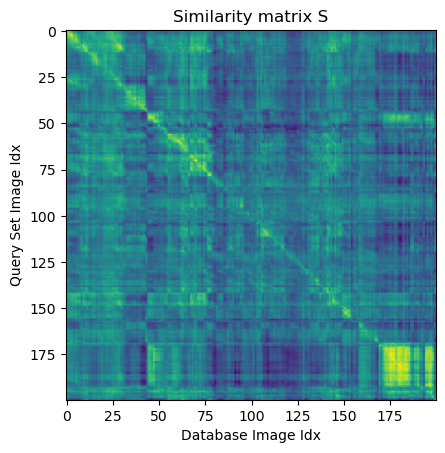

In [52]:
# compare all descriptors and compute similarity matrix S
print('===== Compute cosine similarities S')

# normalize descriptors and compute S-matrix
db_D_holistic = db_D_holistic / np.linalg.norm(db_D_holistic , axis=1, keepdims=True)
q_D_holistic = q_D_holistic / np.linalg.norm(q_D_holistic , axis=1, keepdims=True)
S = np.matmul(db_D_holistic , q_D_holistic.transpose())

# show similarity matrix S
fig = plt.imshow(S)
fig.axes.set_xlabel('Database Image Idx')
fig.axes.set_ylabel('Query Set Image Idx')
fig.axes.set_title('Similarity matrix S')
plt.colorbar()
plt.show()

For AlexNet -- there appears to be a fairly diagonal trend, with some spots where there appears to be no strong match (e.g. around Query image 80), and other spots where there are many strong matches (e.g. around Query image 175).

**Your turn: What's going on here? Visualise the query and database image at index 80 (not a strong match). Then, visualise the query image at index 175, and the database images between 170 and 180 (all strong matches).**

You should be able to adapt the code that we used earlier to visualise the dataset to achieve this.


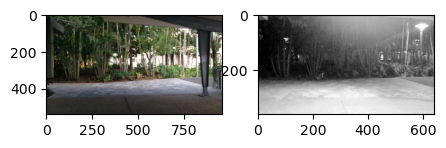

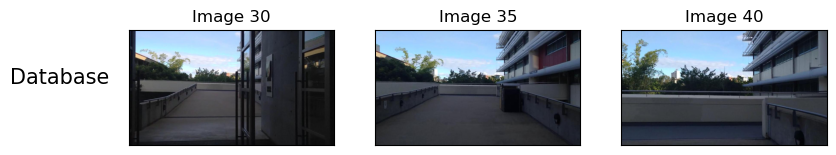

In [53]:
#### Your code goes below



Any hypotheses on why these particular queries either have low similarity with all of the database, or high similarity with multiple images from the database?

Note that this is qualitative analysis, where we make informed guesses about what's going on with the model, but these may not be true.

## Step 6. Assess Performance

Now that we've examined our data and the results, we can use performance metrics to summarise performance on the dataset. This is useful for comparing methods.

To evaluate the quality of a similarity matrix S, we can apply a series of decreasing thresholds $\theta$ to match more and more image pairs. Combined with ground-truth information, each threshold leads to a different set of true positives, false positives, true negatives and false negatives, which then provides one point on the precision-recall curve.

In the following, the precision-recall curve and the area under the precision-recall curve is computed and visualized for *multi-match VPR*, i.e. all matches between each query image and the database have to be identified.

To understand more about these metrics, read [this tutorial paper](https://arxiv.org/pdf/2303.03281.pdf) (pg.10-11).

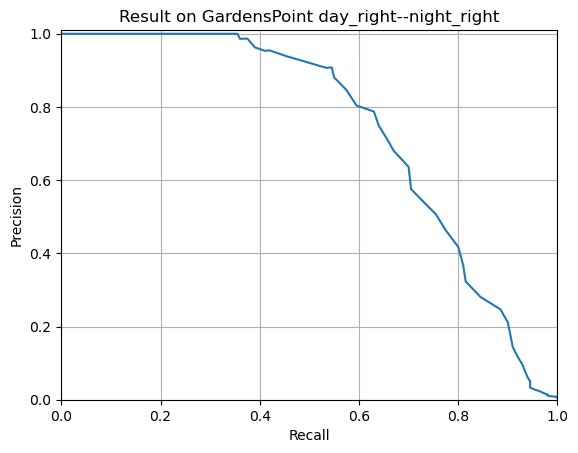

In [44]:
# precision-recall curve
P, R = createPR(S, GThard, GTsoft, matching='multi', n_thresh=100)
plt.figure()
plt.plot(R, P)
plt.xlim(0, 1), plt.ylim(0, 1.01)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Result on GardensPoint day_right--night_right')
plt.grid('on')
plt.draw()



The graph shows the precision-recall curve. A curve closer to the upper right corner would represent better performance. Precision=1 means that no false positives (FP) were extracted. A recall=1 means that all same places were found.

Below, we calculate the area under this curve as a summary metric. The AUPRC performance ranges between 0 and 1 (higher is better).

In [40]:
# area under precision-recall curve (AUPRC)
AUPRC = np.trapz(P, R)
print(f'\n===== AUPRC: {AUPRC:.3f}')


===== AUPRC: 0.739


For AlexNet global descriptor, I get AUPRC 0.195 -- this is not very good.

## Step 7. Compare to another method

**Your turn: re-run the above experiments, now with the HDC-DELF descriptors! Do you have a gut feeling on whether it will do better or worse?**

You should be able to scroll back up and re-run cells after selecting the new descriptor.

Once you do the comparison, try to make some observations beyond comparing the AUPRC. For example, do you observe any difference in the appearance of the similarity matrix?

## Step 8. VPR in the Wild!

Collect some of your own images from outside S block at QUT! You can upload these into the 'MyData' folder in the 'images' folder and test them below. I've put a few placeholders, but you should go take your own. Note: you should probably take images in landscape mode with your phone to match the dataset.

**Your turn: The code below will load in your images, extract their features, but is missing the code to compute the similarity matrix! Add this in yourself, then you will be able to visualise the matches for each image.**

How do the models perform?


In [54]:
 # load images
my_fns_q = glob('MyData/*.jpg')
my_imgs_q = [np.array(Image.open(fn)) for fn in my_fns_q]

print('===== Compute query set descriptors')
q_my_holistic = feature_extractor.compute_features(my_imgs_q)

print('===== Normalize query set descriptors')
q_my_holistic = q_my_holistic / np.linalg.norm(q_my_holistic , axis=1, keepdims=True)

#### Your turn: Create the similarity matrix below



===== Compute query set descriptors
===== Normalize query set descriptors


The similarity matrix is not very helpful to look at with these images, as we don't necessarily know the ground-truth matches. We can however visualise the matches below!

Where the matches correct? If not, have a look at the similarity of the matches compared to the similarity matrix calculated with the normal query set -- do you think the matches were confident matches?

[100   7  43  80]


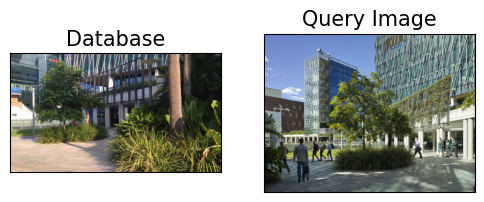

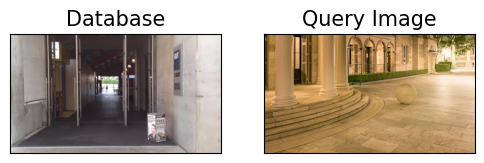

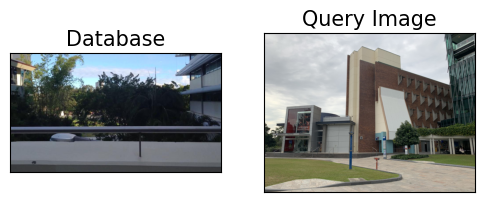

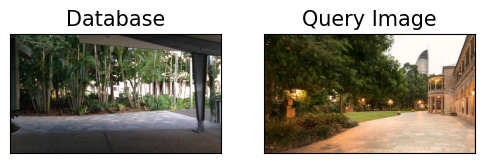

In [58]:
im_matches = np.argmax(S, axis = 0)

for orig_idx in range(len(im_matches)):
    
    fig, ax = plt.subplots(1, 2, figsize = (6, 4))
    
    ax[0].imshow(imgs_db[im_matches[orig_idx]])
    ax[1].imshow(my_imgs_q[orig_idx])
    
    ax[0].set_xticks([]) #turns off axis ticks, which can be nicer for images
    ax[1].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_yticks([])

    ax[0].set_title('Database', rotation = 0, fontsize = 15)
    ax[1].set_title('Query Image', rotation = 0, fontsize = 15)
    
    similarity = np.max(S, axis = 0)[orig_idx]
    fig.suptitle(f'Similarity of match: {similarity}', y = 0.85, fontsize = 15)
    plt.show()